# Calculating Integrated Intensities and Error for Ammonia Data

In order to get a more rigorous filtering for the ammonia data posterior files than taking the rms of the posterior distributions at each of the pixels, I will be taking the integrated intensity of each of the pixels across both the 1-1 and 2-2. From there, we calculate the error of that. Then, I want to set a limit where if the integrated intensity is not above some number times the error, then that pixel will be excluded from the maximum likelihood velocity map.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm
from astropy.stats import sigma_clip

import os

%matplotlib inline
import matplotlib.pyplot as plt

#### Start by opening up the original ammonia data cube.

In [3]:
path = 'L1495-B218_NH3_11.fits'
cube_11 = fits.open(path)
data_11 = cube_11[0].data
data_11 = np.squeeze(data_11)
header_11 = cube_11[0].header
print(header_11)

wcs_11 = wcs.WCS(header_11)

print(wcs_11)
print(data_11.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                 1000                                                  NAXIS4  =                    1                                                  BLOCKED =                    T /Tape may be blocked                             OBJECT  = 'dtest   '           /Source name                                     TELESCOP= 'NRAO_GBT'           /                                                INSTRUME= 'RcvrArra'           /                                                OBSERVER= 'Yancy Sh'           /                                                DATE-OBS= '2012-04-25'         /Obs star

0.07728406227970908


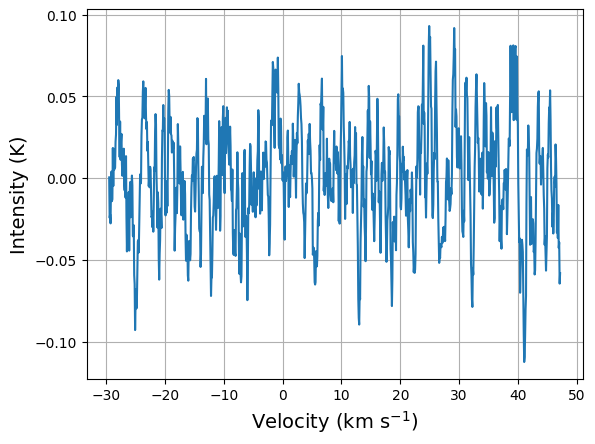

In [78]:
freq_start = header_11["CRVAL3"]
freq_inc = header_11["CDELT3"]

freq_channels = np.arange(header_11["NAXIS3"])

#define velocity as km/s blocks
frequency = freq_start + (freq_inc * freq_channels)
i_frequency = header_11["RESTFREQ"]

velocity = (3E8 * ((i_frequency - frequency)/i_frequency))/1000
velocity = np.array(velocity, dtype = float)
print(velocity[1] - velocity[0])

import scipy.signal

def boxcar_smoothing(data, window_size):
    """Apply boxcar smoothing to data."""
    window = scipy.signal.windows.boxcar(window_size)
    return scipy.signal.convolve(data, window, mode='same') / window_size

#data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smoothed_data = boxcar_smoothing(data_11[:, 272, 1868], 7)
smoothed_velocity = boxcar_smoothing(velocity, 7)

#plt.plot(velocity, data_11[:, 272, 1890])
plt.plot(smoothed_velocity[:-3], smoothed_data[:-3])
plt.xlabel(r'Velocity (km s$^{-1})$', fontsize = 14)
plt.ylabel(r'Intensity (K)', fontsize = 14)
plt.grid()

plt.savefig('example_ammonia_spec_2.png', transparent=True, bbox_inches = 'tight')

#### Open up the Maximum Likelihood Velocity Map

In [10]:
path = 'velocity_grid.fits'
vel_cube = fits.open(path)
vel_data = vel_cube[0].data
vel_header = vel_cube[0].header
#print(header)

wcs_vel = wcs.WCS(vel_header)

print(wcs_vel)
print(vel_data.shape)

print(vel_data[272, 1890])

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)
6.441706726692667


#### Open up the Velocity Dispersion Posterior File

In [23]:
path = 'v1_sigm_post.fits'
disp_cube = fits.open(path)
disp_data = disp_cube[0].data
disp_header = disp_cube[0].header
print(disp_header)

wcs_disp = wcs.WCS(disp_header)

print(wcs_disp)
print(disp_data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                  199                                                  CDELT1  =      -0.001666666707                                                  CDELT2  =       0.001666666707                                                  CRPIX1  =               1100.0                                                  CRPIX2  =               9785.0                                                  CRVAL1  =        170.233333333                                                  CRVAL2  =                  0.0                                                  CTYPE1  = 'GLON-SFL'                    

0.27834170373434464


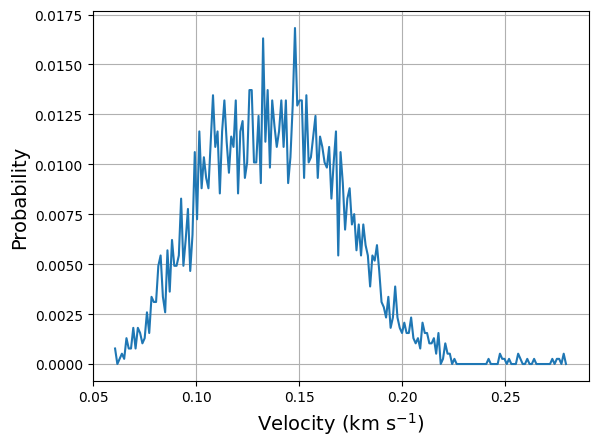

In [24]:
disp_start = disp_header["CRVAL3"]
disp_inc = disp_header["CDELT3"]

disp_channels = np.arange(disp_header["NAXIS3"])

#define velocity as km/s blocks
dispersion = disp_start + (disp_inc * disp_channels)

#plt.plot(dispersion, disp_data[:, 272, 1890])
plt.plot(dispersion, disp_data[:, 218, 1826])
plt.grid()
plt.xlabel(r'Velocity (km s$^{-1}$)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)

plt.savefig('example_posterior_3.png', transparent=True, bbox_inches = 'tight')
print(dispersion[list(disp_data[:, 272, 1890]).index(np.max(disp_data[:, 272, 1890]))])

### Calculate the Integrated Intensities and the RMS

Start by listing out the frequency offsets of the NH$_3$ hyperfine transitions for the (1, 1) inversion transition (Mangum & Shirley, 2015). Then convert those to velocity offsets to be used in the for loop. Now looping over all of the pixels, first all of the pixels that start off as 'NaN' just get appended to the new file as also being 'NaN'. Then for the pixels that do have values, we pull in the maximum likelihood velocity, the raw ammonia spectrum, and the maximum likelihood velocity dispersion. From there, we set bounds around each of the hyperfine lines. We do this by taking the lower and higher velocity offset for each clump of hyperfine transitions and setting a 3\sigma bound on it based on the maximum likelihood velocity dispersion. Then in each of those hyperfine transitions, we take the integrated intensity, by summing up the brightness temperature and multiplying by the velocity resolution to get the integrated intensity with units of K km s$^{-1}$. 

In [25]:
import itertools 
from itertools import filterfalse 

frequency_offsets_MHz = [-1.568487, -1.526950, -0.623306, -0.590338, -0.580921, -0.036536, -0.025538, -0.024394, -0.014977, 0.005848, 
                         0.010515, 0.016847, 0.019932, 0.571792, 0.582790, 0.617700, 1.534050, 1.545049]
central_frequency_MHz = 23694.495487

velocity_offsets = [3E8 * x / central_frequency_MHz / 1000 for x in frequency_offsets_MHz]
velocity_offsets = np.array(velocity_offsets, dtype = float)
#print(velocity_offsets)

integrated_intensity = []
root_mean_sq = []
for i in tqdm(range(800)):
    row_II = []
    row_RMS = []
    for j in range(2200):
        max_velocity = vel_data[i, j]
        if math.isnan(max_velocity):
            row_II.append(max_velocity)
            row_RMS.append(max_velocity)
        else:
            ammonia_data = data_11[:, i, j]
            vel_dispersion = dispersion[list(disp_data[:, i, j]).index(np.max(disp_data[:, i, j]))]
            
            l_bound_1 = max_velocity + velocity_offsets[0] - (3 * vel_dispersion)
            l_bound_1 = list(np.abs(velocity - l_bound_1)).index(np.min(np.abs(velocity - l_bound_1)))
            r_bound_1 = max_velocity + velocity_offsets[1] + (3 * vel_dispersion)
            r_bound_1 = list(np.abs(velocity - r_bound_1)).index(np.min(np.abs(velocity - r_bound_1)))

            sum_1 = np.sum(ammonia_data[l_bound_1 : r_bound_1+1]) * (velocity[1] - velocity[0])

            l_bound_2 = max_velocity + velocity_offsets[2] - (3 * vel_dispersion)
            l_bound_2 = list(np.abs(velocity - l_bound_2)).index(np.min(np.abs(velocity - l_bound_2)))
            r_bound_2 = max_velocity + velocity_offsets[4] + (3 * vel_dispersion)
            r_bound_2 = list(np.abs(velocity - r_bound_2)).index(np.min(np.abs(velocity - r_bound_2)))

            sum_2 = np.sum(ammonia_data[l_bound_2 : r_bound_2+1]) * (velocity[1] - velocity[0])
            
            l_bound_3 = max_velocity + velocity_offsets[5] - (3 * vel_dispersion)
            l_bound_3 = list(np.abs(velocity - l_bound_3)).index(np.min(np.abs(velocity - l_bound_3)))
            r_bound_3 = max_velocity + velocity_offsets[12] + (3 * vel_dispersion)
            r_bound_3 = list(np.abs(velocity - r_bound_3)).index(np.min(np.abs(velocity - r_bound_3)))

            sum_3 = np.sum(ammonia_data[l_bound_3 : r_bound_3+1]) * (velocity[1] - velocity[0])

            l_bound_4 = max_velocity + velocity_offsets[13] - (3 * vel_dispersion)
            l_bound_4 = list(np.abs(velocity - l_bound_4)).index(np.min(np.abs(velocity - l_bound_4)))
            r_bound_4 = max_velocity + velocity_offsets[15] + (3 * vel_dispersion)
            r_bound_4 = list(np.abs(velocity - r_bound_4)).index(np.min(np.abs(velocity - r_bound_4)))

            sum_4 = np.sum(ammonia_data[l_bound_4 : r_bound_4+1]) * (velocity[1] - velocity[0])

            l_bound_5 = max_velocity + velocity_offsets[16] - (3 * vel_dispersion)
            l_bound_5 = list(np.abs(velocity - l_bound_5)).index(np.min(np.abs(velocity - l_bound_5)))
            r_bound_5 = max_velocity + velocity_offsets[17] + (3 * vel_dispersion)
            r_bound_5 = list(np.abs(velocity - r_bound_5)).index(np.min(np.abs(velocity - r_bound_5)))

            sum_5 = np.sum(ammonia_data[l_bound_5 : r_bound_5+1]) * (velocity[1] - velocity[0])

            integrated_int = sum_1 + sum_2 + sum_3 + sum_4 + sum_5

            res = list(filterfalse(np.arange(l_bound_1 - 5, r_bound_1 + 6).__contains__,
                       np.arange(0, 1000)))
            res = list(filterfalse(np.arange(l_bound_2 - 5, r_bound_2 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_3 - 5, r_bound_3 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_4 - 5, r_bound_4 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_5 - 5, r_bound_5 + 6).__contains__,
                       res))
            rms = np.sqrt(np.sum([x**2 for x in ammonia_data[res[50:-50]]])/len(res[50:-50]))

            row_II.append(integrated_int)
            row_RMS.append(rms)
    integrated_intensity.append(row_II)
    root_mean_sq.append(row_RMS)

100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [33:45<00:00,  2.53s/it]


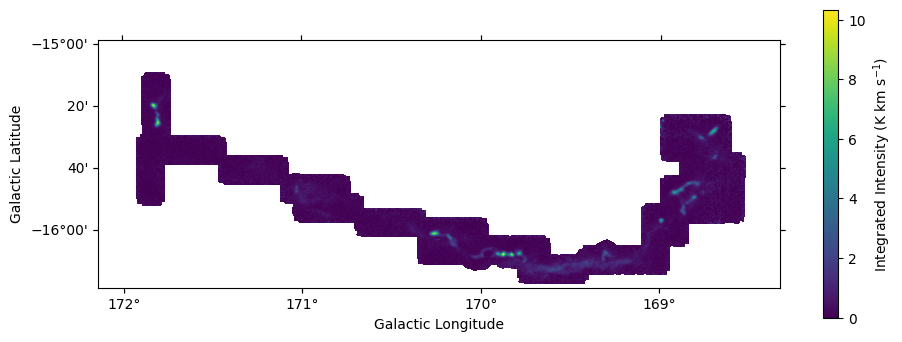

In [26]:
plt.figure(figsize = [11, 4])
plt.subplot(projection = wcs_vel, slices=('x', 'y', 0))
plt.imshow(integrated_intensity, vmin = 0)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(label = r'Integrated Intensity (K km s$^{-1}$)')

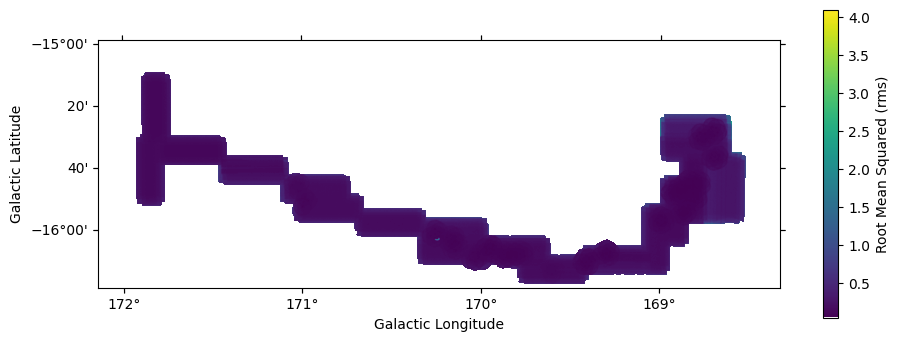

In [27]:
plt.figure(figsize = [11, 4])
plt.subplot(projection = wcs_vel, slices=('x', 'y', 0))
plt.imshow(root_mean_sq)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(label = r'Root Mean Squared (rms)')

### Calculate the Error for the Intgrated Intensity

We do this with the following formula 

$$
\sigma_I = \sigma_T \sqrt{v_{chan} \times v_{interval}}
$$

In this case, $v_{chan}$ is the velocity channel spacing and $v_{interval}$ is the velocity interval over which we calculated the integrated intensity. Because we took the integrated intensity over 5 hyperfine features, we need to add up each of those intervals and then add them up. This error will then be used as the error that the integrated intensity needs to be larger than in order to be counted into the data.

In [28]:
chan_spacing = velocity[1] - velocity[0]

error_ii = []
for i in tqdm(range(800)):
    row_IIE = []
    for j in range(2200):
        max_velocity = vel_data[i, j]
        if math.isnan(max_velocity):
            row_IIE.append(max_velocity)
        else:
            vel_dispersion = dispersion[list(disp_data[:, i, j]).index(np.max(disp_data[:, i, j]))]
            rms = root_mean_sq[i][j]
            
            l_bound_1 = max_velocity + velocity_offsets[0] - (3 * vel_dispersion)
            l_bound_1 = list(np.abs(velocity - l_bound_1)).index(np.min(np.abs(velocity - l_bound_1)))
            r_bound_1 = max_velocity + velocity_offsets[1] + (3 * vel_dispersion)
            r_bound_1 = list(np.abs(velocity - r_bound_1)).index(np.min(np.abs(velocity - r_bound_1)))

            l_bound_2 = max_velocity + velocity_offsets[2] - (3 * vel_dispersion)
            l_bound_2 = list(np.abs(velocity - l_bound_2)).index(np.min(np.abs(velocity - l_bound_2)))
            r_bound_2 = max_velocity + velocity_offsets[4] + (3 * vel_dispersion)
            r_bound_2 = list(np.abs(velocity - r_bound_2)).index(np.min(np.abs(velocity - r_bound_2)))
            
            l_bound_3 = max_velocity + velocity_offsets[5] - (3 * vel_dispersion)
            l_bound_3 = list(np.abs(velocity - l_bound_3)).index(np.min(np.abs(velocity - l_bound_3)))
            r_bound_3 = max_velocity + velocity_offsets[12] + (3 * vel_dispersion)
            r_bound_3 = list(np.abs(velocity - r_bound_3)).index(np.min(np.abs(velocity - r_bound_3)))

            l_bound_4 = max_velocity + velocity_offsets[13] - (3 * vel_dispersion)
            l_bound_4 = list(np.abs(velocity - l_bound_4)).index(np.min(np.abs(velocity - l_bound_4)))
            r_bound_4 = max_velocity + velocity_offsets[15] + (3 * vel_dispersion)
            r_bound_4 = list(np.abs(velocity - r_bound_4)).index(np.min(np.abs(velocity - r_bound_4)))

            l_bound_5 = max_velocity + velocity_offsets[16] - (3 * vel_dispersion)
            l_bound_5 = list(np.abs(velocity - l_bound_5)).index(np.min(np.abs(velocity - l_bound_5)))
            r_bound_5 = max_velocity + velocity_offsets[17] + (3 * vel_dispersion)
            r_bound_5 = list(np.abs(velocity - r_bound_5)).index(np.min(np.abs(velocity - r_bound_5)))

            vel_interval = ((velocity[r_bound_5] - velocity[l_bound_5]) + (velocity[r_bound_4] - velocity[l_bound_4]) + 
                            (velocity[r_bound_3] - velocity[l_bound_3]) + (velocity[r_bound_2] - velocity[l_bound_2]) + 
                            (velocity[r_bound_1] - velocity[l_bound_1]))

            error = rms * np.sqrt(chan_spacing * vel_interval)

            row_IIE.append(error)
    error_ii.append(row_IIE)

100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [01:24<00:00,  9.50it/s]


nan


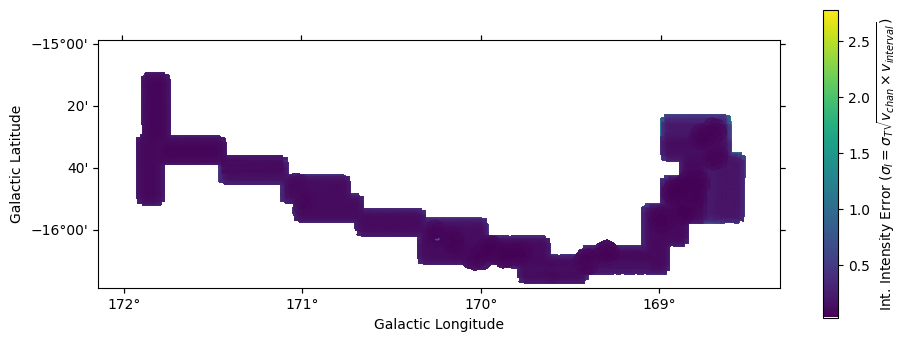

In [29]:
plt.figure(figsize = [11, 4])
plt.subplot(projection = wcs_vel, slices=('x', 'y', 0))
plt.imshow(error_ii)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(label = r'Int. Intensity Error ($\sigma_I = \sigma_T \sqrt{v_{chan} \times v_{interval}}$)')

print(error_ii[50][100])

In [37]:
masked_velocity = []
for i in tqdm(range(800)):
    row_masked = []
    for j in range(2200):
        max_velocity = vel_data[i, j]
        if math.isnan(max_velocity):
            row_masked.append(max_velocity)
        else:
            error = error_ii[i][j]
            intensity = integrated_intensity[i][j]

            if intensity >= error:
                row_masked.append(max_velocity)
            else:
                row_masked.append(integrated_intensity[50][100])

    masked_velocity.append(row_masked)

100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 3429.54it/s]


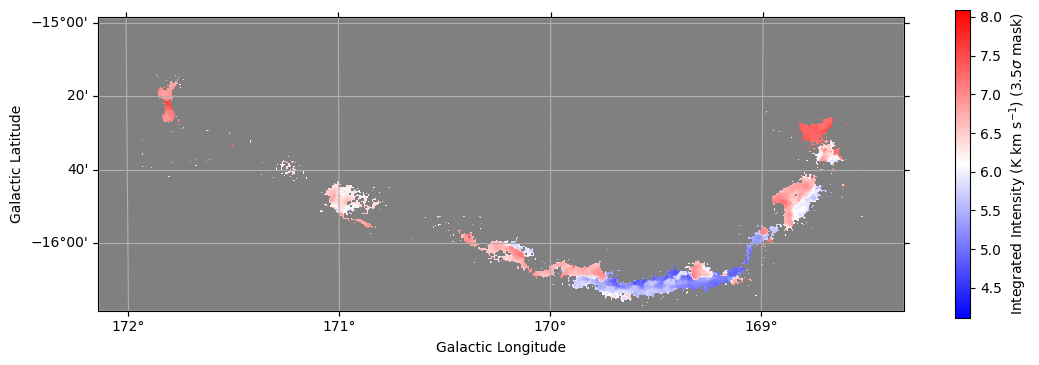

In [38]:
plt.figure(figsize = [13, 4])
ax = plt.subplot(projection = wcs_vel, slices=('x', 'y', 0))
 
# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor("grey")

plt.imshow(masked_velocity, cmap = 'bwr')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(label = r'Integrated Intensity (K km s$^{-1}$) (3.5$\sigma$ mask)')

plt.grid()

output_hdu = wcs_vel.to_fits()
output_hdu[0].data is None

output_hdu[0].data = masked_velocity

output_hdu.writeto("masked_ML_velocity.fits", overwrite=True)

In [4]:
path = 'masked_ML_velocity.fits'
cube = fits.open(path)
masked_vel_data = cube[0].data
header = cube[0].header

wcs_masked_vel = wcs.WCS(header)

In [5]:
path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header

wcs_dist_transform = wcs.WCS(header)

In [6]:
region = 'B213'
path = region + '_velocity_posterior.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

wcs_subregion = wcs.WCS(header)
print(wcs_subregion)
print(data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(47.0) np.float64(9715.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 343  127  199
(199, 127, 343)


In [8]:
list_ = open("Seo_NH3_peaks.txt").read().split()
strings = list_[4:]
ra_strings = []
dec_strings = []
for i in range(39):
    ra_strings.append(strings[i*3])
    dec_strings.append(strings[i*3+1])

ra = []
dec = []
for i in range(39):
    ra_val = ra_strings[i]
    ra_value = float(ra_val[0])*15 + 15*float(ra_val[2:4])/60 + 15*float(ra_val[5:11])/3600
    ra.append(ra_value)

    dec_val = dec_strings[i]
    dec_value = float(dec_val[0:2]) + float(dec_val[3:5])/60 + float(dec_val[6:11])/3600
    dec.append(dec_value)

c = SkyCoord(ra, dec, frame='icrs', unit='deg')
galactic_coords = c.galactic

lon = np.array(galactic_coords.l*u.degree)
lat = np.array(galactic_coords.b*u.degree)

c = SkyCoord(lon, lat, frame='galactic', unit='deg')

pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_dist_transform, origin=1)
pixels_x_vel, pixels_y_vel = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_subregion, origin=1)

170.3131659755382 169.7184408938772
-16.190000391798 -15.978333720009001
1053.0000000000043 1395.9999999999973
70.0 197.0


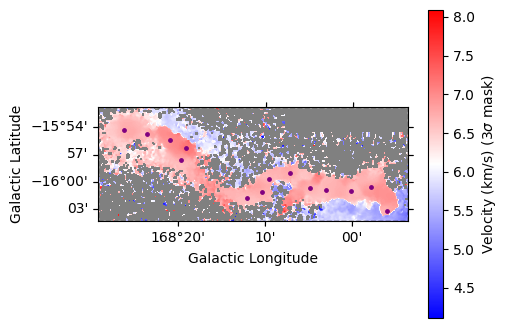

In [12]:
longitude = [135, #B7
            249, #B216
            173, #B218
            343, #B213
            353, #B211
            169 #B10
            ]
latitude = [169, #B7
           169, #B216
           163, #B218
           127, #B213
           133, #B211
           178 #B10
           ]

if region == 'B7':
    index = 0
elif region == 'B216':
    index = 1
elif region == 'B218':
    index = 2
elif region == 'B213':
    index = 3
elif region == 'B211':
    index = 4
elif region == 'B10':
    index = 5

(l_min, b_min, vel), (l_max, b_max, vel) = wcs_subregion.wcs_pix2world([[0, 0, 0], [longitude[index], latitude[index], 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min_pix, b_min_pix, vel), (l_max_pix, b_max_pix, vel) = wcs_vel.wcs_world2pix([[l_min, b_min, vel], [l_max, b_max, vel]], 0)

print(l_min_pix, l_max_pix)
print(b_min_pix, b_max_pix)

plt.figure(figsize = [5, 4])
ax_1 = plt.subplot(111, projection = wcs_subregion, slices=('x', 'y', 0))
im = ax_1.imshow(masked_vel_data, cmap = 'bwr')
plt.scatter(pixels_x, pixels_y, s = 6, c = 'purple')
ax_1.set_facecolor("grey")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_1.set(xlim=(round(l_min_pix), round(l_max_pix)), ylim=(round(b_min_pix), round(b_max_pix)))
cbar = plt.colorbar(im, label = r'Velocity (km/s) (3$\sigma$ mask)')
#ax_1.text(1360, 180, 'B213', fontsize = 16, fontweight = 'bold')
ax_1.add_patch(plt.Rectangle((round(l_min_pix) + 0, round(b_min_pix) + 0), longitude[index], latitude[index], ls="--", ec="k", fc="none"))

343 343
127 127
343 343
127 127
[0.         0.5        0.70710678 1.         1.11803399 1.41421356]
343 127
2.195937949151556


/tmp/ipykernel_405895/3373847104.py:29: RuntimeWarning: invalid value encountered in scalar divide
  x_place.append(float(-grad_x_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
/tmp/ipykernel_405895/3373847104.py:30: RuntimeWarning: invalid value encountered in scalar divide
  y_place.append(float(-grad_y_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
/tmp/ipykernel_405895/3373847104.py:57: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (perp_x_spines[i][j] * grad_x_vel[i][j] + perp_y_spines[i][j] * grad_y_vel[i][j])/(np.sqrt((perp_x_spines[i][j])**2 + (perp_y_spines[i][j])**2))


[(0.0, 342.5), (0.0, 126.5)]

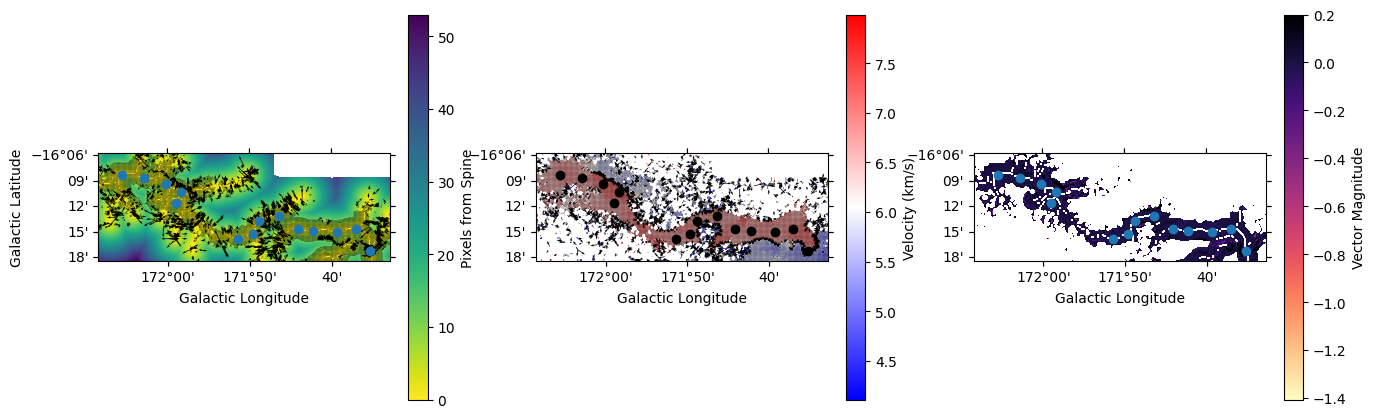

In [13]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = longitude[index], latitude[index]
lon_start, lat_start = 0, 0

subregion_vel = masked_vel_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_vel, grad_x_vel = divergence(subregion_vel) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_vel), len(grad_y_vel))

#print(subregion_vel)

subregion_spines = distance_transform_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

perp_x_spines = []
perp_y_spines = []
diff_1_form_mag = []
for i in range(lat_length):
    x_place = []
    y_place = []
    for j in range(lon_length):
        #print(j, i, list(x_0).index(j), y_0[list(x_0).index(j)]) 
        #print x coord, y coord, the index of the spine in that column, the y coordinate of the spine in that column
        if subregion_spines[i][j] <= 12:
            x_place.append(float(-grad_x_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
            y_place.append(float(-grad_y_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
            diff_1_form_mag.append(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))
        else:
            x_place.append(float(0))
            y_place.append(float(0))
    perp_x_spines.append(np.array(x_place))
    perp_y_spines.append(np.array(y_place))

print(np.unique(diff_1_form_mag))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

print(len(x), len(y))

perp_grad_x = []
perp_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    #x_values = []
    #y_values = []
    summed = []
    for j in range(len(x)):
        proj_length = (perp_x_spines[i][j] * grad_x_vel[i][j] + perp_y_spines[i][j] * grad_y_vel[i][j])/(np.sqrt((perp_x_spines[i][j])**2 + (perp_y_spines[i][j])**2))
        magnitude = np.sqrt((perp_x_spines[i][j] * proj_length)**2 + (perp_y_spines[i][j] * proj_length)**2)
        
        perp_grad_x.append(-grad_x_spines[i][j] * proj_length)
        perp_grad_y.append(-grad_y_spines[i][j] * proj_length)

        x_vals.append(x[j])
        y_vals.append(y[i])
        
        #summed.append(np.sqrt((-grad_x_spines[i][j] * proj_length)**2 + (-grad_y_spines[i][j] * proj_length)**2))
        summed.append(proj_length)
        
    #perp_grad_x.append(x_values)
    #perp_grad_y.append(y_values)
    divergence.append(summed)

print(np.nanmax(divergence))

plt.figure(figsize = [16, 5])

ax_3 = plt.subplot(133, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'magma_r', vmax = 0.2)
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
#plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Vector Magnitude')

ax_2 = plt.subplot(132, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_2.imshow(subregion_vel, cmap = 'bwr', vmin = np.nanmin(subregion_vel), vmax = np.nanmax(subregion_vel))
#im = ax_2.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_2.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_2.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
plt.quiver(x_vals, y_vals, perp_grad_x, perp_grad_y, color = 'black')
#plt.quiver(x, y, -grad_x_spines, -grad_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))

4751 3992 2830 1653


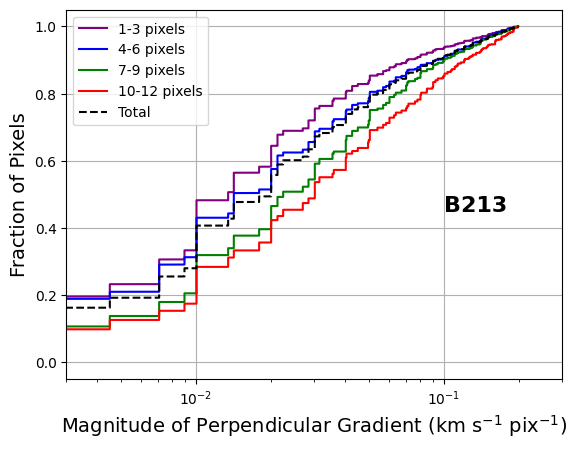

In [17]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if np.abs(divergence[j][i]) <= 0.2:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 4 <= subregion_spines[j][i] <= 6:
            if np.abs(divergence[j][i]) <= 0.2:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 7 <= subregion_spines[j][i] <= 9:
            if np.abs(divergence[j][i]) <= 0.2:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 10 <= subregion_spines[j][i] <= 12:
            if np.abs(divergence[j][i]) <= 0.2:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

print(len(vec_mag_low), len(vec_mag_med), len(vec_mag_high), len(vec_mag_higher))

plt.xscale('log')
plt.xlim(3E-3, 0.3)
plt.ylim(-0.05, 1.05)
plt.text(0.1, 0.45, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'upper left')
plt.xlabel(r'Magnitude of Perpendicular Gradient (km s$^{-1}$ pix$^{-1}$)', fontsize = 14)
plt.ylabel('Fraction of Pixels', fontsize = 14)
plt.grid()
plt.savefig('Figures/B213_cdf_perp.png', transparent=True, bbox_inches = 'tight')

343 343
127 127
343 343
127 127


/tmp/ipykernel_369181/976712576.py:58: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (par_x_spines[i][j] * grad_x_vel[i][j] + par_y_spines[i][j] * grad_y_vel[i][j])/np.sqrt((par_x_spines[i][j])**2 +


[(0.0, 342.5), (0.0, 126.5)]

/home/ljsteffes/.venv/lib/python3.12/site-packages/matplotlib/quiver.py:632: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/ljsteffes/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


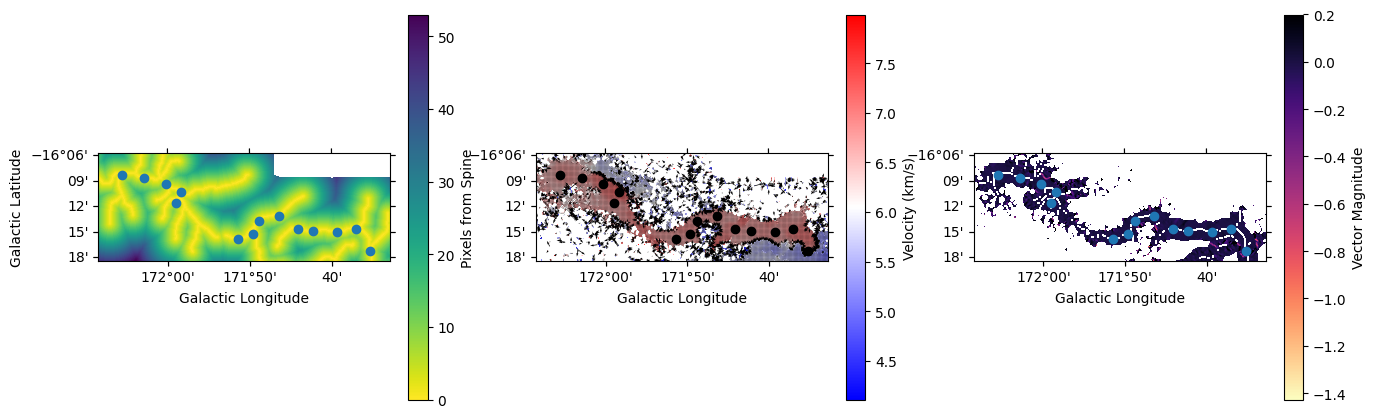

In [86]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = longitude[index], latitude[index]
lon_start, lat_start = 0, 0

subregion_vel = masked_vel_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_vel, grad_x_vel = divergence(subregion_vel) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_vel), len(grad_y_vel))

#print(subregion_vel)

subregion_spines = distance_transform_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

x_0 = []
y_0 = []
for i in range(lat_length):
    for j in range(lon_length):
        if subregion_spines[i][j] == 0:
            x_0.append(j)
            y_0.append(i)
            #print(i, j, grad_x_spines[i][j], grad_y_spines[i][j])

par_x_spines = []
par_y_spines = []
for i in range(lat_length):
    x_place = []
    y_place = []
    for j in range(lon_length):
        #print(j, i, list(x_0).index(j), y_0[list(x_0).index(j)]) 
        #print x coord, y coord, the index of the spine in that column, the y coordinate of the spine in that column
        if subregion_spines[i][j] <= 12:
            x_place.append(float(-grad_y_spines[i][j]))
            y_place.append(float(grad_x_spines[i][j]))
        else:
            x_place.append(float(0))
            y_place.append(float(0))
    par_x_spines.append(np.array(x_place))
    par_y_spines.append(np.array(y_place))

para_grad_x = []
para_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    summed = []
    for j in range(len(x)):
        proj_length = (par_x_spines[i][j] * grad_x_vel[i][j] + par_y_spines[i][j] * grad_y_vel[i][j])/np.sqrt((par_x_spines[i][j])**2 + 
                                                                                                       (par_y_spines[i][j])**2)
        #magnitude = np.sqrt((par_x_spines[i][j] * proj_length)**2 + (par_y_spines[i][j] * proj_length)**2)

        if magnitude <= 0.2:
            #Do something
        
            para_grad_x.append(par_x_spines[i][j] * proj_length)
            para_grad_y.append(par_y_spines[i][j] * proj_length)

            x_vals.append(x[j])
            y_vals.append(y[i])

        summed.append(proj_length)
        
    divergence.append(summed)

plt.figure(figsize = [16, 5])

ax_3 = plt.subplot(133, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'magma_r', vmax = 0.2)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
cbar = plt.colorbar(im, label = 'Vector Magnitude')

ax_2 = plt.subplot(132, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_2.imshow(subregion_vel, cmap = 'bwr', vmin = np.nanmin(subregion_vel), vmax = np.nanmax(subregion_vel))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_2.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_2.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
plt.quiver(X, Y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
#plt.quiver(x_vals, y_vals, grad_x_spines, grad_y_spines, color = 'black')
plt.quiver(x_vals, y_vals, para_grad_x, para_grad_y, color = 'black')
#plt.quiver(X, Y, par_x_spines, par_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
#print(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
#ax_1.text(2, 2, 'Parallel 0-Form', size = 12, color = 'white', fontweight = 'bold')

5039 4477 3385 2084


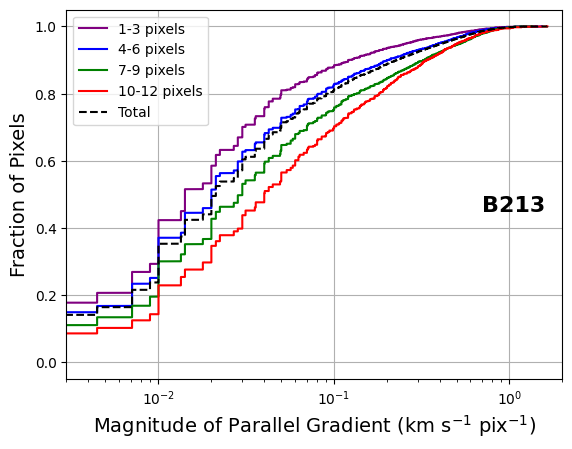

In [90]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 4 <= subregion_spines[j][i] <= 6:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 7 <= subregion_spines[j][i] <= 9:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 10 <= subregion_spines[j][i] <= 12:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

print(len(vec_mag_low), len(vec_mag_med), len(vec_mag_high), len(vec_mag_higher))

plt.xscale('log')
plt.xlim(3E-3, 2)
plt.ylim(-0.05, 1.05)
plt.text(0.7, 0.45, region, fontsize = 16, fontweight = 'bold')

plt.xlabel(r'Magnitude of Parallel Gradient (km s$^{-1}$ pix$^{-1}$)', fontsize = 14)
plt.ylabel('Fraction of Pixels', fontsize = 14)
plt.legend()
plt.grid()
plt.savefig('Figures/B213_cdf_para.png', transparent=True, bbox_inches = 'tight')